# About this notebook 

#### Objective: Exploratory Data Analysis


<div class="span5 alert alert-success">
<p> <B> This notebook will explore and analyze the two data files provided...  </B>  
    
1. User table (takehome_users) with data on 12,000 users who signed up for the product over the last two years.  
<br>
2. Usage Summary table ( "takehome_user_engagement" ) that has a row for each day
that a user logged into the product.
    
 <br>
 </p>
</div>

<div class="span5 alert alert-success">
<p> <B> 1. User table ( "takehome_users" ) includes the following fields... </B>  
<I>name:</I> the user's name  
<br>
<I>object_id:</I> the user's id
<br>
<I>email:</I> email address  
<br>
<I>creation_source:</I> how their account was created. This takes on one
of 5 values:  
○ PERSONAL_PROJECTS: invited to join another user's personal workspace  
○ GUEST_INVITE: invited to an organization as a guest (limited permissions)  
○ ORG_INVITE: invited to an organization (as a full member)  
○ SIGNUP: signed up via the website  
○ SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their loginid)  
<br>
<I>creation_time:</I> when they created their account  
<br>
<I>last_session_creation_time:</I> unix timestamp of last login    
<br>
<I>opted_in_to_mailing_list:</I> whether they have opted into receiving marketing emails  
<br>
<I>enabled_for_marketing_drip:</I> whether they are on the regular marketing email drip  
<br>
<I>org_id:</I> the organization (group of users) they belong to  
<br>
<I>invited_by_user_id:</I> which user invited them to join (if applicable).
 </p>
</div>

<div class="span5 alert alert-success">
<p> <B> 2. Usage Summary ( "takehome_user_engagement" ) includes the following fields... </B>  
<I>timestamp:</I> the login date/time  
<I>user_id:</I> the user's id
<br>
<I>visitor_id:</I>
<br>
 </p>
</div>

In [25]:
import warnings
warnings.filterwarnings('ignore')

%cd C:\Users\Ken\Documents\KenP\Applications-DataScience\SpringboardCourseWork\Data-Challenges\Relax Data Challenge

C:\Users\Ken\Documents\KenP\Applications-DataScience\SpringboardCourseWork\Data-Challenges\Relax Data Challenge


<div class="span5 alert alert-info">
<p> <B>  Imports and Data Loading: </B>  </p>
</div>

In [26]:
#Imports
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [27]:
#Import the take_home users file
dfu = pd.read_csv('takehome_users.csv', encoding = "ISO-8859-1")
dfu.head(1)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,4/22/2014 3:53,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0


In [28]:
#Import the user engagement file
dfue = pd.read_csv('takehome_user_engagement.csv', encoding = "ISO-8859-1")

In [29]:
#Identify is a user is adopted (logged in at least 3 times in any 7 day period) or not adopted
dfue['datetimestamp'] =  pd.to_datetime(dfue['time_stamp'])
dfue['datestamp'] = dfue['datetimestamp'].dt.date
dfue = dfue.drop(['time_stamp','visited','datetimestamp'],axis=1)

dfue = dfue.sort_values(['user_id', 'datestamp']).drop_duplicates()

dfue.head(1)

,user_id,datestamp
0,1,2014-04-22


<div class="span5 alert alert-info">
<p> <B>  Missing Data: </B>   

</p>
</div>

In [30]:
# Percentage of missing values in each column
pd.DataFrame(
    dfue.isnull().sum() / len(dfue),
    columns=['% Missing Values']
).transpose()

,user_id,datestamp
% Missing Values,0.0,0.0


<div class="span5 alert alert-info">
<p> <B>  Identify adopted users (0 = not adopted, 1 = adopted): </B>   

</p>
</div>

In [31]:
#function for list of three dates
def threeentries(inlist):
    result = 0
    
    datediff = inlist[2] - inlist[0]
    
    if datediff.days < 8:
        result = 1
    
    return result

In [32]:
#function for list with many entries (more than three)
def manyentries(inlist):
    result = 0
    
    entry = 2
    
    while (entry < len(inlist) and result == 0) :
        datediff = inlist[entry] - inlist[entry - 2]
        
        if datediff.days < 8:
            result = 1
        
        entry = entry + 1
    
    return result

In [33]:
#functions to decide if user is adopted (logged in at least 3 times in a 7 day period)
def isadopted(input):    
    inlist = list(input)   
    listentriescount = 0
    adoptionstatus = 0
    
    #count entries in list
    for i, d in enumerate(inlist):
        listentriescount = listentriescount + 1
    
    #determine if adopted
    if listentriescount < 3:
        adoptionstatus = 0
        
    elif listentriescount == 3:
         adoptionstatus = threeentries(inlist)
        
    else:
         adoptionstatus = manyentries(inlist)
    
    return adoptionstatus

In [34]:
#Group by userid, collapse the datestamps for each userid into a list, and determine if user is or isn't adopted
dfue2 = pd.DataFrame(dfue.groupby('user_id')['datestamp'].apply(lambda x:isadopted(x)))
dfue2 = dfue2.reset_index()
dfue2.columns = ['userid','adoptionstatus']
dfue2.head(1)

,userid,adoptionstatus
0,1,0


<div class="span5 alert alert-info">
<p> <B>  Add "Adopted Status" to Take_Home_Users file </B>  </p>
</div>

In [35]:
#concatenate dfu (users file) with dfue2 (adoption status)
dfu3 = dfu.set_index('object_id')

dfue2.columns = ('object_id','adoptionstatus')
dfue3 = dfue2.set_index('object_id')

m = pd.concat([dfu3, dfue3], axis=1)

In [36]:
#Some users have never logged in (user engagement file has no entry).  Set these users to not adopted
m['adoptionstatus'].fillna(0, inplace=True)
m.head(1)

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adoptionstatus
object_id,,,,,,,,,,
1,4/22/2014 3:53,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0


In [37]:
##Export to csv
out_csv = 'mergeresults.csv'
m.to_csv(out_csv)

<div class="span5 alert alert-info">
<p> <B>  Exploratory Data Analysis </B>  </p>
</div>

<div class="span5 alert alert-success">
<p> Dataframe of columns of interest
 </p>
</div>

In [38]:
#Create InvitedByUser column as true or false
inviteduserlist = []

for x in m.invited_by_user_id:
    if x > 0:
        inviteduserlist.append(1)
    else:
        inviteduserlist.append(0)

m['invitedbyuser'] = inviteduserlist

In [39]:
#Create dataframe of columns of interest
dfi = m[['creation_source','opted_in_to_mailing_list','enabled_for_marketing_drip','invitedbyuser','adoptionstatus']].reset_index()
dfi.head(1)

,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,invitedbyuser,adoptionstatus
0,1,GUEST_INVITE,1,0,1,0.0


<div class="span5 alert alert-success">
<p> Adopted Users
 </p>
</div>

In [40]:
#Count the number of adopted users
dfc = dfi[['adoptionstatus']]
dfc = dfc.reset_index()

dfc2 = dfc.groupby('adoptionstatus').count()
dfc2 = dfc2.reset_index()
dfc2.columns = ('type','count')
dfc2

,type,count
0,0.0,10344
1,1.0,1656


In [41]:
#percent adopted
percentadopted = dfc2.iloc[1]/(dfc2.iloc[1] + dfc2.iloc[0])
print('percent adopted: ' + str(percentadopted.count))

percent adopted: <bound method Series.count of type     1.000
count    0.138
dtype: float64>


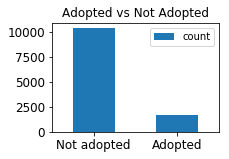

In [42]:
#bar plot of adopted users
dfadoptionbarplot = dfc2[['count']]

ax = dfadoptionbarplot.plot(kind='bar', title ="Adopted vs Not Adopted", figsize=(3, 2), legend=True, fontsize=12, rot=0)

x_labels = ['Not adopted', 'Adopted']
ax.set_xticklabels(x_labels)
plt.show()

<div class="span5 alert alert-success">
<p> Creation Source
 </p>
</div>

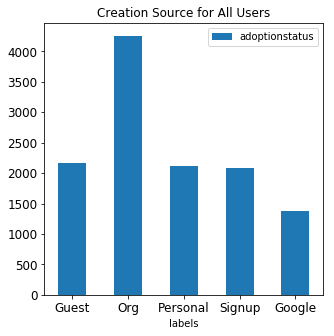

In [43]:
#Bar chart of Creation Source breakout for all users
dfcs = dfi[['creation_source','adoptionstatus']]
dfcs = dfcs.groupby('creation_source').agg('count')
dfcs['labels'] = ['Guest', 'Org','Personal', 'Signup', 'Google']
dfcs = dfcs.set_index('labels')

dfcs.head()
ax = dfcs.plot(kind='bar', title ="Creation Source for All Users", figsize=(5, 5), legend=True, fontsize=12, rot=0)
plt.show()

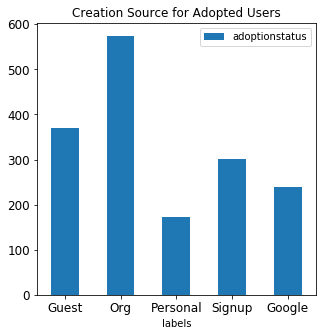

In [44]:
#Bar chart of Creation Source breakout for adopted users
dfcs = dfi[['creation_source','adoptionstatus']]
dfcs = dfcs[dfcs.adoptionstatus == 1]
dfcs = dfcs.groupby('creation_source').agg('count')
dfcs['labels'] = ['Guest', 'Org','Personal', 'Signup', 'Google']
dfcs = dfcs.set_index('labels')

dfcs.head()
ax = dfcs.plot(kind='bar', title ="Creation Source for Adopted Users", figsize=(5, 5), legend=True, fontsize=12, rot=0)
plt.show()

<div class="span5 alert alert-success">
<p> Invited by User
 </p>
</div>

In [45]:
#number of users that were invited by another user
dfcs = dfi[['invitedbyuser','adoptionstatus']]

dfibu = dfcs.groupby('invitedbyuser').agg('count')
dfibu = dfibu.rename({'adoptionstatus':'count'},axis=1)
dfibu.head()

,count
invitedbyuser,
0,5583
1,6417


In [46]:
#number of adopted users that were invited by another user
dfcs = dfi[['invitedbyuser','adoptionstatus']]
dfcs = dfcs[dfcs.adoptionstatus == 1]
dfibu = dfcs.groupby('invitedbyuser').agg('count')
dfibu = dfibu.rename({'adoptionstatus':'count'},axis=1)
dfibu.head()

,count
invitedbyuser,
0,713
1,943


<div class="span5 alert alert-success">
<p> Correlation Matrix
 </p>
</div>

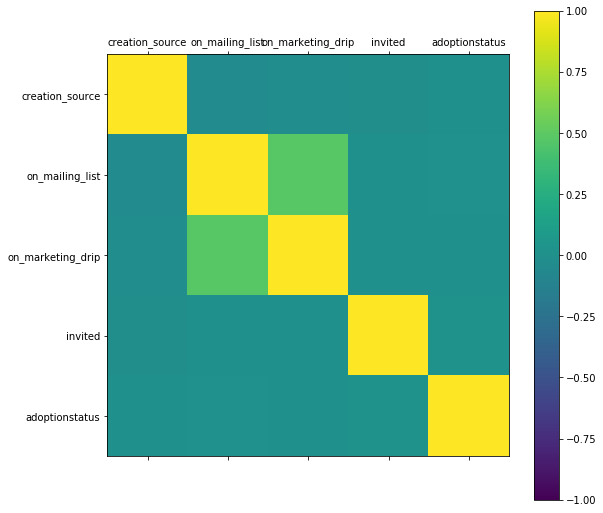

In [47]:
#derive correlations among the variables of interest
featurenames = ['creation_source','on_mailing_list','on_marketing_drip','invited','adoptionstatus']

correlations = dfi.corr()

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations,vmin=-1, vmax=1)
fig.colorbar(cax)
ticks=np.arange(0,5,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(featurenames)
ax.set_yticklabels(featurenames)
plt.show()